In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
import warnings
warnings.filterwarnings('ignore')

In [3]:
def movMin(datas,k):
    result = np.empty_like(datas)
    start_pt = 0
    end_pt = int(np.ceil(k/2))

    for i in range(len(datas)):
        if i < int(np.ceil(k/2)):
            start_pt = 0
        if i > len(datas) - int(np.ceil(k/2)):
            end_pt = len(datas)
        result[i] = np.min(datas[start_pt:end_pt])
        start_pt += 1
        end_pt +=1
    return result

In [4]:
def base_removal(x):
    time_vector = np.linspace(0,len(x), len(x))
    try:
        peaks_location, _ = scipy.signal.find_peaks(x, prominence=0.2)
        peak_dist = [0] * len(peaks_location)
        for i in range(len(peaks_location)-1):
            peak_dist[i] = peaks_location[i+1] - peaks_location[i]
        median_peak_dist = np.median(peak_dist)
        #print(median_peak_dist)
        #plt.plot(peaks_location, x[peaks_location],"x")
        if (median_peak_dist<60 or median_peak_dist>100):
            median_peak_dist= 66
        baseline = movMin(x, median_peak_dist)
        P = np.polyfit(time_vector,baseline,int(np.round(median_peak_dist)))
    except:
        polynomial_order = 66
        P = np.polyfit(time_vector,x, polynomial_order)
    baseline_fit = np.polyval(P, time_vector)
    Y = x - baseline_fit
    return Y

In [5]:
def z_renorm(x):
    return (x - np.mean(x))/np.std(x)

In [6]:
def zero_one_renorm(x):
    return (x- np.min(x))/(np.max(x) - np.min(x))

In [7]:
def ppg_ecg_filter(x):
    u = base_removal(x)
    u = z_renorm(u)
    u = zero_one_renorm(u)
    return u

In [8]:
def VPPG(ppg, n = 10, f = 15, fs = 125.0, padding = 50):
    
    vppg = np.gradient(ppg)
    b,a = scipy.signal.butter(n, f, 'lp', fs=125.0)
    sos =scipy.signal.tf2sos(b,a)
    w, gd = scipy.signal.group_delay((b, a))
    gd_mean = int(np.round(np.mean(gd)))
    filtered = scipy.signal.sosfilt(sos, vppg)
    delay = gd_mean + 1
    return filtered[padding + delay : -padding + delay], vppg[padding:-padding]

In [9]:
def APPG(vppg, n = 10, f = 15, fs = 125.0, padding = 50):

    appg = np.gradient(vppg)
    b,a = scipy.signal.butter(n, f, 'lp', fs=125.0)
    sos =scipy.signal.tf2sos(b,a)
    w, gd = scipy.signal.group_delay((b, a))
    gd_mean = int(np.round(np.mean(gd)))
    filtered = scipy.signal.sosfilt(sos, appg)
    delay = 2*gd_mean + 1

    return filtered[padding + delay: - padding +delay], appg[padding:padding]

    return filtered

In [10]:
def get_SBP_DBP(ABP, prom= 4.2, verbose=0):
    peaks_max_location, _ = scipy.signal.find_peaks(ABP, prominence= prom, distance = 60)
    peaks_min_location, _ = scipy.signal.find_peaks(-ABP, prominence= prom, distance = 60)
    SBP_peaks = ABP[peaks_max_location]
    DBP_peaks = ABP[peaks_min_location]
    sbp = np.mean(SBP_peaks)
    dbp = np.mean(DBP_peaks)
    error_sbp = np.std(SBP_peaks)
    error_dbp = np.std(DBP_peaks)
    if verbose==1:
        plt.plot(ABP)
        plt.plot(peaks_max_location, ABP[peaks_max_location], "x")
        plt.plot(peaks_min_location, ABP[peaks_min_location], "x")
    return (sbp, dbp, error_sbp, error_dbp)

In [11]:
def find_peaks_valleys(x, prom = 0.5):
     if len(x)<1000:
          print("only ", len(x), " elements. Discarded")
          return 0
     peaks_max_X, _ = scipy.signal.find_peaks(x, prominence= prom, distance = 30)
     peaks_max_Y = x[peaks_max_X]
     peaks_min_X, _ = scipy.signal.find_peaks(-x, prominence= prom, distance = 30)
     peaks_min_Y = x[peaks_min_X]
     plt.figure()
     plt.plot(x)
     plt.plot(peaks_max_X[:len(peaks_max_Y)],peaks_max_Y, "x")
     plt.plot(peaks_min_X[:len(peaks_min_Y)],peaks_min_Y, "x")


In [12]:
def control_sequence(x, type, prom, verbose = 0,  sensitivity = 18, no_graph = 1):
#SBP <80 and >190 are removed
#DBP <50 and >120 are removed
#|SBP-DBP|<20 or >120 are removed
     decision = 1
     if type=="abp":
          sbp,dbp,_,_ = get_SBP_DBP(x)
          range_abp = abs(sbp-dbp)
          if (sbp<80 or sbp>190 or dbp<50 or dbp>120):
               print("WRONG ABP RANGE")
               decision = 0
               return decision
          
          if (range_abp<20 or range_abp>120):
               print("WRONG ABP RANGE")
               decision =0
               return decision


     if len(x)<1000:
          print("only ", len(x), " elements. Discarded")
          decision = 0
          return decision

     #calcoliamo la std del segnale
     std = np.std(x)
     mean = np.mean(x)
     #calcoliamo picchi
     #calc_prom = mean + ((np.max(x) - mean)/2.0) - np.min(x)
     calc_prom = abs(np.median(x) - np.min(x)+0.1)
     if type=="abp":
          calc_prom = 10
     
     peaks_max_X, _ = scipy.signal.find_peaks(x, prominence= calc_prom, distance = 25)
     peaks_max_Y = x[peaks_max_X]
     peaks_min_X, _ = scipy.signal.find_peaks(-x, prominence= calc_prom, distance = 25)
     peaks_min_Y = x[peaks_min_X]
     #print(len(peaks_max_X), len(peaks_min_X))

    
     peak_max_dist_X = [0] * (len(peaks_max_X)-1)
     for i in range(len(peaks_max_X)-1):
          peak_max_dist_X[i] = peaks_max_X[i+1] - peaks_max_X[i]

     peak_min_dist_X = [0] * (len(peaks_min_X)-1)
     for i in range(len(peaks_min_X)-1):
          peak_min_dist_X[i] = peaks_min_X[i+1] - peaks_min_X[i]

     if len(peak_max_dist_X)==0:
          print("ERROR: NO PEAKS MAX FOUND")
          decision = 0
          return decision
     
     if len(peak_min_dist_X)==0:
          print("ERROR: NO PEAKS MIN FOUND")
          decision = 0
          return decision

     #print(len(peak_max_dist_X), len(peak_min_dist_X))

     mean_peaks_max_Y = np.mean(peaks_max_Y)
     mean_peaks_min_Y = np.mean(peaks_min_Y)
     mean_peaks_max_X = np.mean(peak_max_dist_X)
     mean_peaks_min_X = np.mean(peak_min_dist_X)
     #minmax_distance_max_peak_X = abs(np.max(peak_max_dist_X) - np.min(peak_max_dist_X))
     #minmax_distance_min_peak_X = abs(np.max(peak_min_dist_X) - np.min(peak_min_dist_X))
     #minmax_distance_max_peak_Y = abs(np.max(peaks_max_Y) - np.min(peaks_max_Y))
     #minmax_distance_min_peak_Y = abs(np.max(peaks_min_Y) - np.min(peaks_min_Y))
     std_max_dist_X = np.std(peak_max_dist_X)
     std_min_dist_X = np.std(peak_min_dist_X)
     std_peaks_max_Y = np.std(peaks_max_Y)
     std_peaks_min_Y = np.std(peaks_min_Y)
     #print(peak_max_dist_X)
     #print(peaks_max_Y)
     if no_graph==0:
          plt.figure()
          plt.plot(x)
          plt.plot(peaks_max_X[:len(peaks_max_Y)],peaks_max_Y, "x")
          plt.plot(peaks_min_X[:len(peaks_min_Y)],peaks_min_Y, "x")
    
    #control over sigma
     #if abs(std_max_dist_X - std_min_dist_X)>3:
     #     decision = 0
    
     upper_maximum_lim_X = mean_peaks_max_X + sensitivity*std_max_dist_X
     lower_maximum_lim_X = mean_peaks_max_X - sensitivity*std_max_dist_X
     upper_minimum_lim_X = mean_peaks_min_X + (sensitivity+1)*std_min_dist_X
     lower_minimum_lim_X = mean_peaks_min_X - (sensitivity+1)*std_min_dist_X
     upper_maximum_lim_Y = mean_peaks_max_Y + sensitivity*std_peaks_max_Y
     lower_maximum_lim_Y = mean_peaks_max_Y - sensitivity*std_peaks_max_Y
     upper_minimum_lim_Y = mean_peaks_min_Y + (sensitivity+1)*std_peaks_min_Y
     lower_minimum_lim_Y = mean_peaks_min_Y - (sensitivity+1)*std_peaks_min_Y

    
     if np.max(peak_max_dist_X)>upper_maximum_lim_X:
          if verbose==1:
               print("maximum distance of the peaks too high")
               print(peak_max_dist_X,upper_maximum_lim_X)
          decision = 0
     if np.min(peak_max_dist_X)<lower_maximum_lim_X:
          if verbose==1:
               print("minimum distance of the peaks too low")
               print(peak_max_dist_X,lower_maximum_lim_X)
          decision = 0
     if np.max(peak_min_dist_X)>upper_minimum_lim_X:
          if verbose==1:
               print("maximum distance of the valleys too high")
               print(peak_min_dist_X,upper_minimum_lim_X)
          decision = 0
     if np.min(peak_min_dist_X)<lower_minimum_lim_X:
          if verbose==1:
               print("minimum distance of the valleys too low")
               print(peak_min_dist_X,lower_minimum_lim_X)
          decision = 0
          
     if np.max(peaks_max_Y)>upper_maximum_lim_Y:
          if verbose==1:
               print("maximum y of peaks too high")
               print(peaks_max_Y,upper_maximum_lim_Y)
          decision = 0
     if np.min(peaks_max_Y)<lower_maximum_lim_Y:
          if verbose==1:
               print("minimum y of peaks too low")
               print(peaks_max_Y,lower_maximum_lim_Y)
          decision = 0
     if np.max(peaks_min_Y)>upper_minimum_lim_Y:
          if verbose==1:
               print("maximum y of valleys too high")
               print(peaks_min_Y,upper_minimum_lim_Y)
          decision = 0
     if np.min(peaks_min_Y)<lower_minimum_lim_Y:
          if verbose==1:
               print("minimum y of valleys too low")
               print(peaks_min_Y,lower_minimum_lim_Y)
          decision = 0
     
     if std_max_dist_X>20:
          if verbose==1:
               print("standard dev of the distance of peaks too high")
               print(std_max_dist_X)
     #     decision = 0
     #if std_min_dist_X>10:
     #    decision = 0



     if verbose==1:
          #print("std:",std,", std_max_dist_X: ", std_max_dist_X,", std_min_dist_X: ", std_min_dist_X,", std_peaks_max_Y: ",std_peaks_max_Y,", std_peaks_min_Y: ", std_peaks_min_Y, ", max-min-peak_max_Y: ",minmax_distance_max_peak_Y,", max-min-peak_min_Y :", minmax_distance_max_peak_Y,", max-min-peak_min_X :",minmax_distance_min_peak_X,", max-min-peak_max_X :", minmax_distance_max_peak_X )
          #print(std,std_max_dist_X,std_min_dist_X,mean_peaks_max_X,mean_peaks_min_X,"maxs and mins: ",np.max(peak_max_dist_X),np.min(peak_max_dist_X),np.max(peak_min_dist_X), np.min(peak_min_dist_X) )
          #print(upper_maximum_lim_X, lower_maximum_lim_X, upper_minimum_lim_X, lower_minimum_lim_X)

          #print(std,std_peaks_max_Y,std_peaks_min_Y,mean_peaks_max_Y,mean_peaks_min_Y,"maxs and mins: ",np.max(peaks_max_Y),np.min(peaks_max_Y),np.max(peaks_min_Y), np.min(peaks_min_Y) )
          #print(upper_maximum_lim_Y, lower_maximum_lim_Y, upper_minimum_lim_Y, lower_minimum_lim_Y)
          #print(abs(std_max_dist_X - std_min_dist_X))
          print("decision:", decision)


    
     return decision
    

In [13]:
def generate_all(start, ppg, ecg,abp, pad = 200, increase = 1000, verbose=0 , sensitivity = 18, no_graph=1):
    decision = 1
    ppg_raw = ppg[start-pad:start+increase+pad]
    ecg_raw = ecg[start-pad:start+increase+pad]
    abp_raw = abp[start-pad:start+increase+pad]
    ecg_f = ppg_ecg_filter(ecg_raw)
    ppg_f = ppg_ecg_filter(ppg_raw)
    VPPG_d, VPPG_nf = VPPG(ppg_f, 2, 12, padding=int(pad/2.0))
    APPG_d, APPG_nf = VPPG(VPPG_d, 2,10, padding=int(pad/2.0))
    final_ppg =ppg_f[pad:-pad]
    final_ecg = ecg_f[pad:-pad]
    final_vppg = VPPG_d[int(pad/2.0): -int(pad/2.0)]
    final_appg = APPG_d
    final_abp = abp_raw[pad:-pad]
    #control over the sequence
    #find_peaks_valleys(ecg_f[0:1000], prom= 0.4)
    ecg_decision = control_sequence(final_ecg, "ecg", prom=0.3, verbose=verbose, sensitivity=sensitivity, no_graph = no_graph)
    ppg_decision = control_sequence(final_ppg, "ppg", prom=0.2, verbose=verbose, sensitivity=sensitivity, no_graph = no_graph)
    abp_decision = control_sequence(final_abp, "abp", prom = 10, verbose=verbose, sensitivity=sensitivity, no_graph = no_graph)
    sbp,dbp,_,_ = get_SBP_DBP(final_abp)

    decision = ecg_decision and ppg_decision and abp_decision



    return final_ppg, final_ecg, final_vppg, final_appg,final_abp, sbp, dbp,decision

In [73]:
#open file .mat
path = "C:/Users/feder/Desktop/data/"
f = h5py.File(path + "Part_1.mat")
cell = f['Part_1'][11][0]
#plt.plot(f[cell][:,0])
ppg = f[cell][:,0]
ecg = f[cell][:,2]
abp = f[cell][:,1]
print(len(ppg), len(ecg), len(abp))

2000 2000 2000


maximum distance of the peaks too high
[64, 65, 62, 63, 63, 63, 65, 65, 66, 65, 110, 67, 67, 69] 103.40050937349108
decision: 0
minimum distance of the peaks too low
[65, 63, 64, 63, 63, 63, 62, 65, 65, 66, 46, 73, 57, 68, 67] 46.233625733494094
decision: 0
minimum distance of the peaks too low
[63, 64, 63, 63, 63, 63, 64, 65, 67, 65, 43, 67, 68, 66] 45.65525220305443
decision: 0


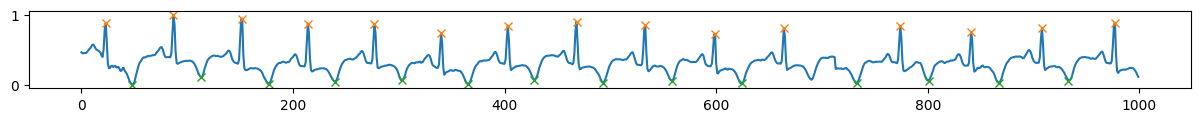

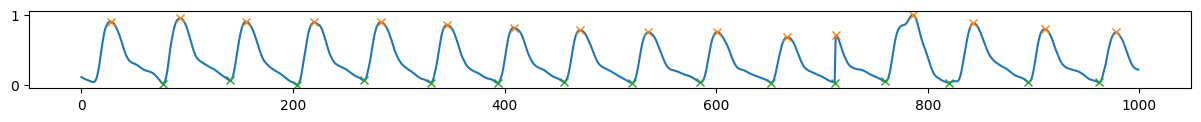

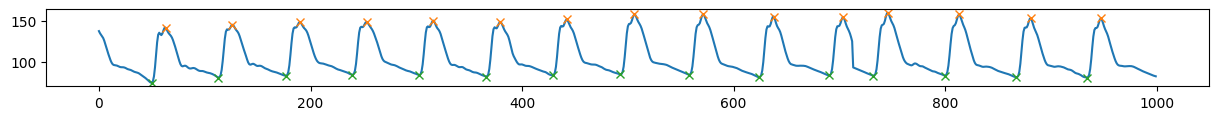

In [74]:
plt.rcParams["figure.figsize"] = (15,1)
result = generate_all(500, ppg, ecg, abp, verbose = 1, sensitivity = 3, no_graph=0)

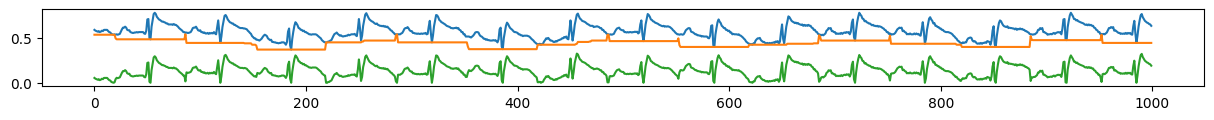

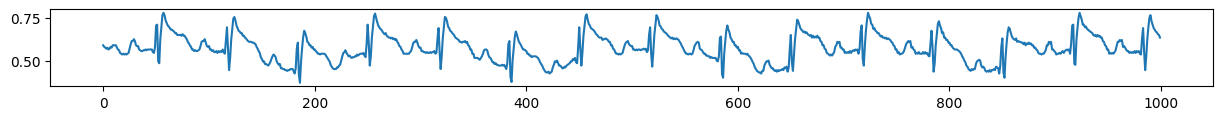

In [15]:
plt.rcParams["figure.figsize"] = (15,1)
st = 500
fin= st+1000
#result = generate_all(3500, ppg, ecg, abp, verbose = 1, sensitivity = 3, no_graph=0)
#ecg = ppg_ecg_filter(ecg[st:fin])
#ppg = ppg_ecg_filter(ppg[st:fin])
ecg_n = ecg[st:fin]
plt.plot(ecg_n)
ecg_baserem = base_removal(ecg_n)
ecg_movmin = movMin(ecg_n, 66)
plt.plot(ecg_movmin)
#plt.plot(ecg_n)
#plt.plot(ecg_movmin)
plt.plot(ecg_n - ecg_movmin)
find_peaks_valleys(ecg[st:fin], prom= 0.5)
#find_peaks_valleys(ppg[st:fin], prom= 0.2)
#find_peaks_valleys(abp[st:fin], prom= 10)


In [51]:
#open file .mat
path = "C:/Users/feder/Desktop/data/"
f = h5py.File(path + "Part_1.mat")
cell = f['Part_1'][64][0]
#plt.plot(f[cell][:,0])
ppg = f[cell][:,0]
ecg = f[cell][:,2]
abp = f[cell][:,1]

In [ ]:
total=0
c=0
for i in range(500,len(ppg)-1000,1000):
    total+=1
    result = generate_all(i, ppg, ecg, abp, verbose = 0, sensitivity = 3, no_graph=1)
    #print(i,i+1000,result[7], result[5], result[6])
    if result[7]==1:
        c+=1
    else:
        print(i)
        print("---------------")
    
    
print(c,"/",total)

In [ ]:
#let's see the length of all cells

path = "C:/Users/feder/Desktop/data/"
f = h5py.File(path + "Part_1.mat")
cells = f['Part_1']

for i in range(len(cells)):
    cell = cells[i][0]
    if len(f[cell][:,0])>15000:
        print(len(f[cell][:,0]))

In [ ]:
#let's see how many samples survive:
#open file .mat
path = "C:/Users/feder/Desktop/data/"
f = h5py.File(path + "Part_1.mat")
cells = f['Part_1']
total=0
c=0
for i in range(len(cells)):
    cell = cells[i][0]
    ppg = f[cell][:,0]
    ecg = f[cell][:,2]
    abp = f[cell][:,1]
    t=0
    cc=0
    print("-------- start:"+str(i)+"--------")
    for j in range(500,len(ppg)-1000,1000):
        total+=1
        t+=1
        result = generate_all(j, ppg, ecg, abp, verbose = 0, sensitivity = 3, no_graph=1)
        #print(i,i+1000,result[7], result[5], result[6])
        if result[7]==1:
            c+=1
            cc+=1
    print(cc,"/",t)
    
    
print(c,"/",total)


In [ ]:
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (15,1)
pad = 50
start = 5500
ppg_to_correct = ppg[start-pad:start+1000+pad]
ecg_to_correct = ecg[start-pad:start+1000+pad]
abp_to_correct = abp[start-pad:start+1000+pad]
ECG_d = ppg_ecg_filter(ecg_to_correct)
PPG_d = ppg_ecg_filter(ppg_to_correct)
VPPG_d, VPPG_nf = VPPG(PPG_d, 2, 12)
APPG_d, APPG_nf = VPPG(VPPG_d, 2,10)
plt.figure("ECG")
plt.plot(ECG_d[50:-50])
plt.figure("PPG")
plt.plot(PPG_d[50:-50])
plt.figure("VPPG")
delay = 1
plt.plot(VPPG_d)
plt.figure("APPG")
plt.plot(APPG_d)
plt.figure("ABP")
plt.plot(abp_to_correct)

In [ ]:
result = get_SBP_DBP(abp_to_correct, prom= 4.2)
print("SBP: "+str(result[0]) + " +- " + str(result[2]))
print("DBP: "+str(result[1]) + " +- " + str(result[3]))

SBP: 114.94544113552774 +- 3.1148275706921185
DBP: 59.20821264769236 +- 1.0010388476822007


In [ ]:
#distribution of SBP and DBP?
list_sbp = []
list_dbp = []
path = "C:/Users/feder/Desktop/data/"
f = h5py.File(path + "Part_1.mat")
cells = f['Part_1']
for i in range(len(cells)):
    print("-----",i,"-----")
    cell = cells[i][0]
    abp = f[cell][:,1]
    for j in range(500,len(abp)-1000,1000):
        sbp,dbp,_,_ = get_SBP_DBP(abp[j:j+1000])
        print(sbp,dbp)
        list_sbp.append(sbp)
        list_dbp.append(dbp)

79774 79774


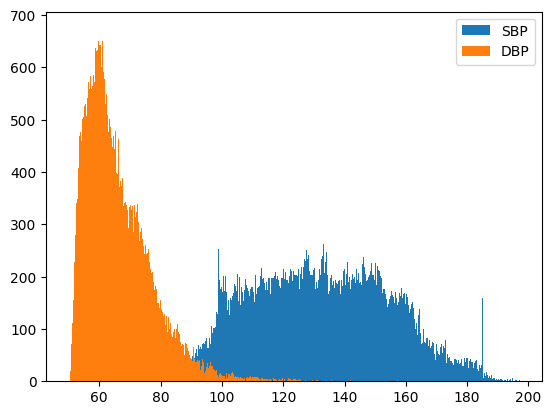

In [33]:
print(len(list_sbp), len(list_dbp))
b = 700
plt.hist(list_sbp, bins=b, label = "SBP")
plt.hist(list_dbp, bins=b, label = "DBP")
plt.legend()
#SBP <80 and >190 are removed
#DBP <50 and >120 are removed
#|SBP-DBP|<20 or >120 are removed

In [ ]:
#now that we cleared the data, we need to save the new database. We have 4 parts. Each about 60k elements to save.
#The best 

In [29]:
#let's write 3 files with ecg,ppg, and abp samples. Those files can be used to calculate
#the vppg,appg and the 2D scalogram and the sbp,dbp


In [ ]:
import csv
file_to_write_path = "C:/Users/feder/Desktop/data/results/"

for i in range(1,5):
    f1 = open(file_to_write_path+"ppg_"+str(i)+".csv", 'w+')
    f2 = open(file_to_write_path+"ecg_"+str(i)+".csv", 'w+')
    f3 = open(file_to_write_path+"abp_"+str(i)+".csv", 'w+')
    f4 = open(file_to_write_path+"vppg_"+str(i)+".csv", 'w+')
    f5 = open(file_to_write_path+"appg_"+str(i)+".csv", 'w+')
    f6 = open(file_to_write_path+"bp_"+str(i)+".csv", 'w+')
    path = "C:/Users/feder/Desktop/data/"
    f = h5py.File(path + "Part_"+str(i)+".mat")
    cells = f["Part_"+str(i)]
    total=0
    c=0
    for i in range(len(cells)):
        cell = cells[i][0]
        ppg = f[cell][:,0]
        ecg = f[cell][:,2]
        abp = f[cell][:,1]
        t=0
        cc=0
        print("-------- start:"+str(i)+"--------")
        for j in range(500,len(ppg)-1000,1000):
            total+=1
            t+=1
            result = generate_all(j, ppg, ecg, abp, verbose = 0, sensitivity = 3, no_graph=1)
            #final_ppg, final_ecg, final_vppg, final_appg,final_abp, sbp, dbp,decision

            if result[7]==1:
                writer1 = csv.writer(f1)
                writer2 = csv.writer(f2)
                writer3 = csv.writer(f3)
                writer4 = csv.writer(f4)
                writer5 = csv.writer(f5)
                writer6 = csv.writer(f6)

                sbp,dbp,_,_ = get_SBP_DBP(result[4])
                writer1.writerow(result[0])#ppg
                writer2.writerow(result[1])#ecg
                writer3.writerow(result[4])#abp
                writer4.writerow(result[2])#vppg
                writer5.writerow(result[3])#appg
                writer6.writerow([sbp,dbp])#sbp
                c+=1
                cc+=1
        print(cc,"/",t)
    f1.close()
    f2.close()
    f3.close()
    f4.close()
    f5.close()
    f6.close()

    
    print(c,"/",total)

In [ ]:
#Let's try to lead the saved csv files
ppg = []
ecg=[]
abp=[]
vppg = []
appg = []
bp = []
file_to_write_path = "C:/Users/feder/Desktop/data/results/"
from numpy import genfromtxt
for i in range(1,5):
     
     ppg.append( genfromtxt(file_to_write_path+"ppg_"+str(i)+".csv", delimiter=','))
     ecg.append( genfromtxt(file_to_write_path+"ecg_"+str(i)+".csv", delimiter=','))
     abp.append( genfromtxt(file_to_write_path+"abp_"+str(i)+".csv", delimiter=','))
     vppg.append( genfromtxt(file_to_write_path+"vppg_"+str(i)+".csv", delimiter=','))
     appg.append( genfromtxt(file_to_write_path+"appg_"+str(i)+".csv", delimiter=','))
     bp.append( genfromtxt(file_to_write_path+"bp_"+str(i)+".csv",  delimiter=','))
     print(i)

ppg = np.array(ppg)
ecg = np.array(ecg)
abp = np.array(abp)
vppg = np.array(vppg)
appg = np.array(appg)
bp = np.array(bp)

print(ppg.shape,ecg.shape,abp.shape,vppg.shape,appg.shape,bp.shape)

In [35]:
ppg[0].shape

(64010, 1000)

In [40]:
print(ppg[0].shape[0] + ppg[1].shape[0] + ppg[2].shape[0] + ppg[3].shape[0])

250371


In [45]:
def compact_array(x):
    x_c = x[0]
    x_c = np.append(x_c,x[1], axis = 0)
    x_c = np.append(x_c,x[2], axis = 0)
    x_c = np.append(x_c,x[3], axis = 0)
    return x_c

In [ ]:
ppg_completo = compact_array(ppg)
ecg_completo = compact_array(ecg)
abp_completo = compact_array(abp)
vppg_completo = compact_array(vppg)
appg_completo = compact_array(appg)
bp_completo = compact_array(bp)


In [48]:
print(ppg_completo.shape, ecg_completo.shape, abp_completo.shape, vppg_completo.shape, appg_completo.shape, bp_completo.shape)

(250371, 1000) (250371, 1000) (250371, 1000) (250371, 1000) (250371, 1000) (250371, 2)


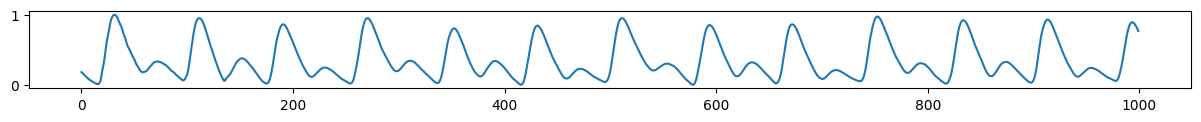

In [39]:
plt.rcParams["figure.figsize"] = (15,1)
plt.plot(my_data[32234])

In [58]:
#convert the numpy object to h5py so we can read it faster in google colab in future

h5f = h5py.File(file_to_write_path + 'bp_completo.h5', 'w')
h5f.create_dataset("bp", data=bp_completo)
h5f.close()


In [52]:
h5f.close()

(250371, 1000)


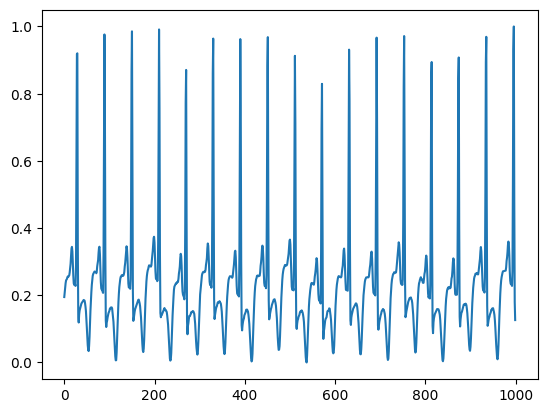

In [68]:
#let's load the h5 and see if it works
h5f = h5py.File(file_to_write_path +'ecg_completo.h5','r')
b = h5f['ecg']
print(b.shape)
plt.plot(b[0])
